# Importation des bibliothèques nécessaires
Importer les bibliothèques nécessaires, y compris pandas, numpy, scikit-learn, et matplotlib.

In [64]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for plots
#sns.set(style="whitegrid")

import matplotlib.pyplot as plt
plt.style.use('ggplot')  # Appliquer le style ggplot


# Chargement des données
Charger les fichiers CSV HDFS_occurence_matrix_HDFS_train.csv, HDFS_occurence_matrix_HDFS_valid.csv, et HDFS_occurence_matrix_HDFS_test.csv dans des DataFrames pandas.

In [65]:
# Chargement des données
train_df = pd.read_csv('HDFS_results/Event_occurence_matrix_HDFS_train.csv')
valid_df = pd.read_csv('HDFS_results/Event_occurence_matrix_HDFS_valid.csv')
test_df = pd.read_csv('HDFS_results/Event_occurence_matrix_HDFS_test.csv')

# Afficher les premières lignes des DataFrames pour vérifier le chargement
print(train_df.head())
print(valid_df.head())
print(test_df.head())

                    BlockId    Label  Type    Time   Date  E1  E2  E3  E4  E5  \
0   blk_-100000266894974466  Success     0   20106  81110   3   3   3   3   3   
1  blk_-1000014584150379967  Success     0   15117  81110   3   3   3   3   3   
2  blk_-1000028658773048709  Success     0  221431  81110   3   3   3   3   0   
3  blk_-1000054577281647820  Success     0   12444  81110   3   3   3   3   3   
4  blk_-1000083860370843431  Success     0  211524  81109   3   3   3   3   3   

   ...  E20  E21  E22  E23  E24  E25  E26  E27  E28  E29  
0  ...    0    0    0    0    0    0    0    0    0    0  
1  ...    0    0    0    0    0    0    0    0    0    0  
2  ...    0    0    0    0    0    0    0    0    0    0  
3  ...    0    0    0    0    0    0    0    0    0    0  
4  ...    0    0    0    0    0    0    0    0    0    0  

[5 rows x 34 columns]
                    BlockId    Label  Type   Time   Date  E1  E2  E3  E4  E5  \
0  blk_-1000028658773048709  Success     0  44331  81111

# Analyse des variables et traitement des corrélations
Calculer la matrice de corrélation sur les variables indépendantes dans l'ensemble d'entraînement. Identifier et supprimer les variables fortement corrélées (corrélation > 0,9).

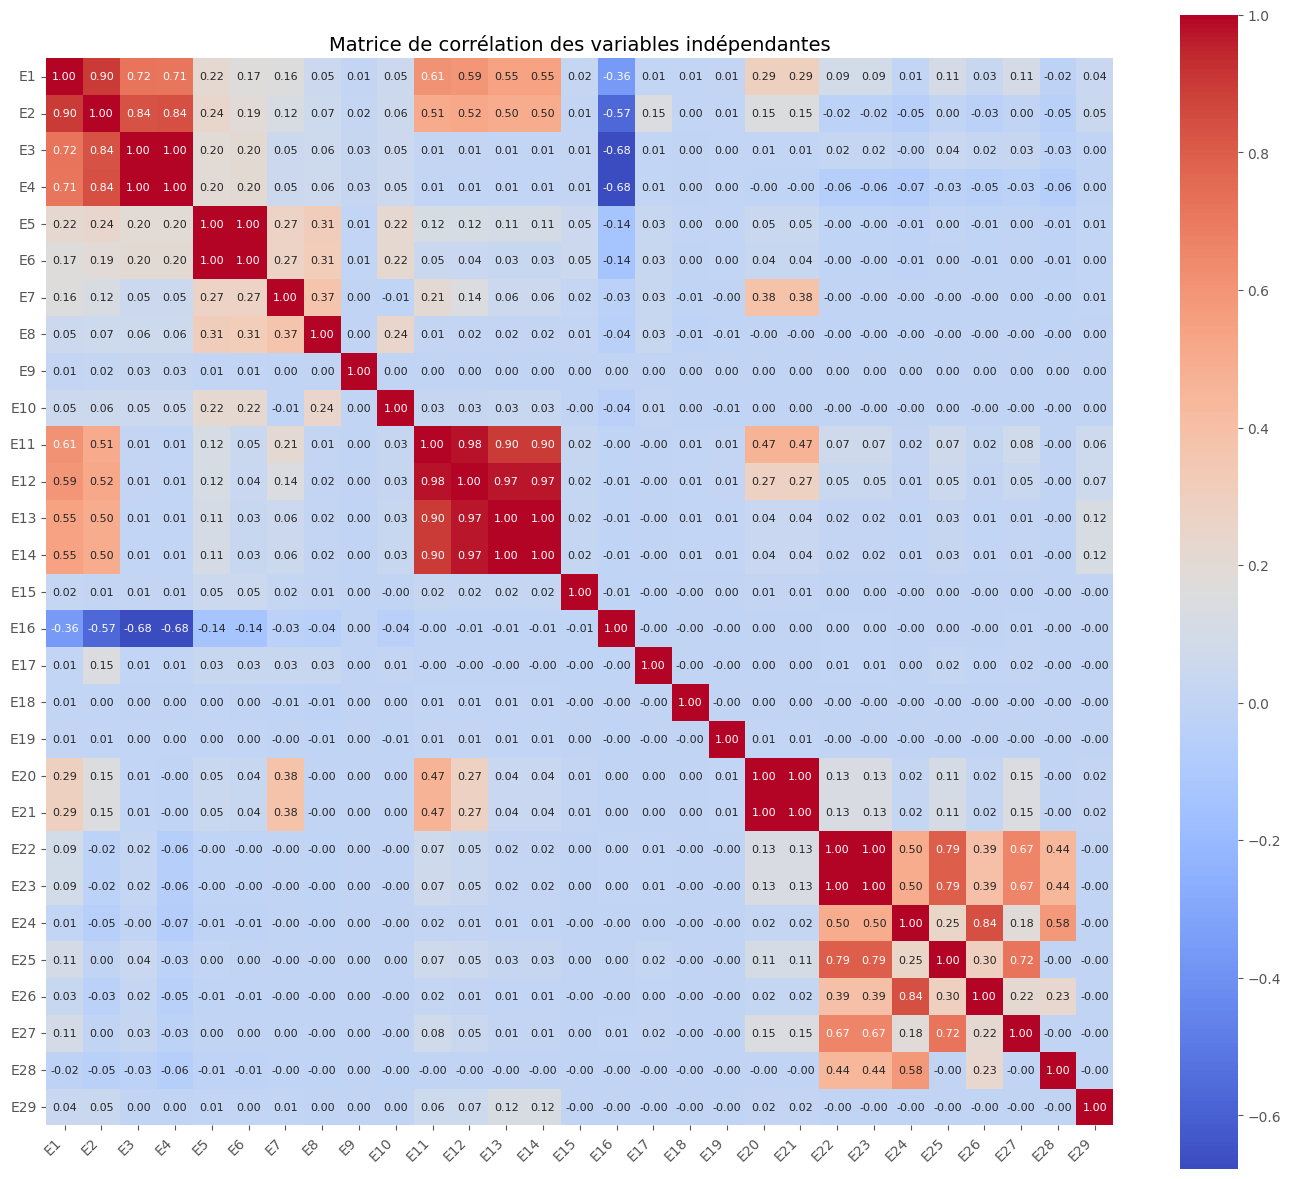

Variables supprimées en raison d'une forte corrélation: {'E4', 'E21', 'E12', 'E2', 'E23', 'E14', 'E13', 'E6'}
Aperçu des DataFrames réduits :
                    BlockId    Label  Type    Time   Date  E1  E3  E5  E7  E8  \
0   blk_-100000266894974466  Success     0   20106  81110   3   3   3   6   3   
1  blk_-1000014584150379967  Success     0   15117  81110   3   3   3   6   3   
2  blk_-1000028658773048709  Success     0  221431  81110   3   3   0   0   0   
3  blk_-1000054577281647820  Success     0   12444  81110   3   3   3   7   4   
4  blk_-1000083860370843431  Success     0  211524  81109   3   3   3   1   2   

   ...  E18  E19  E20  E22  E24  E25  E26  E27  E28  E29  
0  ...    0    0    0    0    0    0    0    0    0    0  
1  ...    0    0    0    0    0    0    0    0    0    0  
2  ...    0    0    0    0    0    0    0    0    0    0  
3  ...    0    0    0    0    0    0    0    0    0    0  
4  ...    0    0    0    0    0    0    0    0    0    0  

[5 rows x 26 col

In [66]:
# Suppression des colonnes non indépendantes et calcul de la matrice de corrélation
correlation_matrix = train_df.drop(columns=['BlockId', 'Label', 'Type', 'Time', 'Date']).corr()

# Affichage de la matrice de corrélation avec des ajustements pour éviter le chevauchement
plt.figure(figsize=(14, 12))  # Augmenter la taille du graphique
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    square=True, 
    annot_kws={"size": 8}  # Taille des annotations
)

# Ajuster l'alignement des étiquettes des axes
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotation des étiquettes sur l'axe x
plt.yticks(rotation=0, fontsize=10)  # Rotation des étiquettes sur l'axe y

plt.title('Matrice de corrélation des variables indépendantes', fontsize=14)
plt.tight_layout()  # Ajuste automatiquement les marges pour éviter les chevauchements
plt.show()

# Identification des variables fortement corrélées (corrélation > 0.9)
high_corr_var = set()
threshold = 0.9

# Parcourir les éléments de la matrice de corrélation
for i in range(len(correlation_matrix.columns)):
    for j in range(i):  # Éviter les doublons et la diagonale
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_var.add(colname)

# Suppression des variables fortement corrélées
train_df_reduced = train_df.drop(columns=high_corr_var)
valid_df_reduced = valid_df.drop(columns=high_corr_var)
test_df_reduced = test_df.drop(columns=high_corr_var)

# Affichage des variables supprimées
print(f"Variables supprimées en raison d'une forte corrélation: {high_corr_var}")

# Vérification des DataFrames réduits
print("Aperçu des DataFrames réduits :")
print(train_df_reduced.head())
print(valid_df_reduced.head())
print(test_df_reduced.head())

# Création des échantillons avec bootstrap
Utiliser le bootstrap pour créer des échantillons de l'ensemble d'entraînement. Chaque échantillon a la même taille que l'ensemble d'entraînement d'origine (avec remplacement).

Pour chaque échantillon bootstrap, entraîner un modèle de régression logistique sur l'ensemble d'entraînement. Valider ce modèle sur un ensemble de validation distinct.

Répéter les étapes de création d'échantillons bootstrap et de modélisation un nombre défini de fois. Stocker les performances (Précision, Rappel et AUC).


Performances moyennes pour Logistic Regression:
Accuracy moyenne: 0.6265
Precision moyenne: 0.0442
Recall moyenne: 0.6819
F1 moyenne: 0.0830
Roc_auc moyenne: 0.6990

Performances moyennes pour Random Forest:
Accuracy moyenne: 0.9465
Precision moyenne: 0.5698
Recall moyenne: 0.3315
F1 moyenne: 0.3715
Roc_auc moyenne: 0.7608


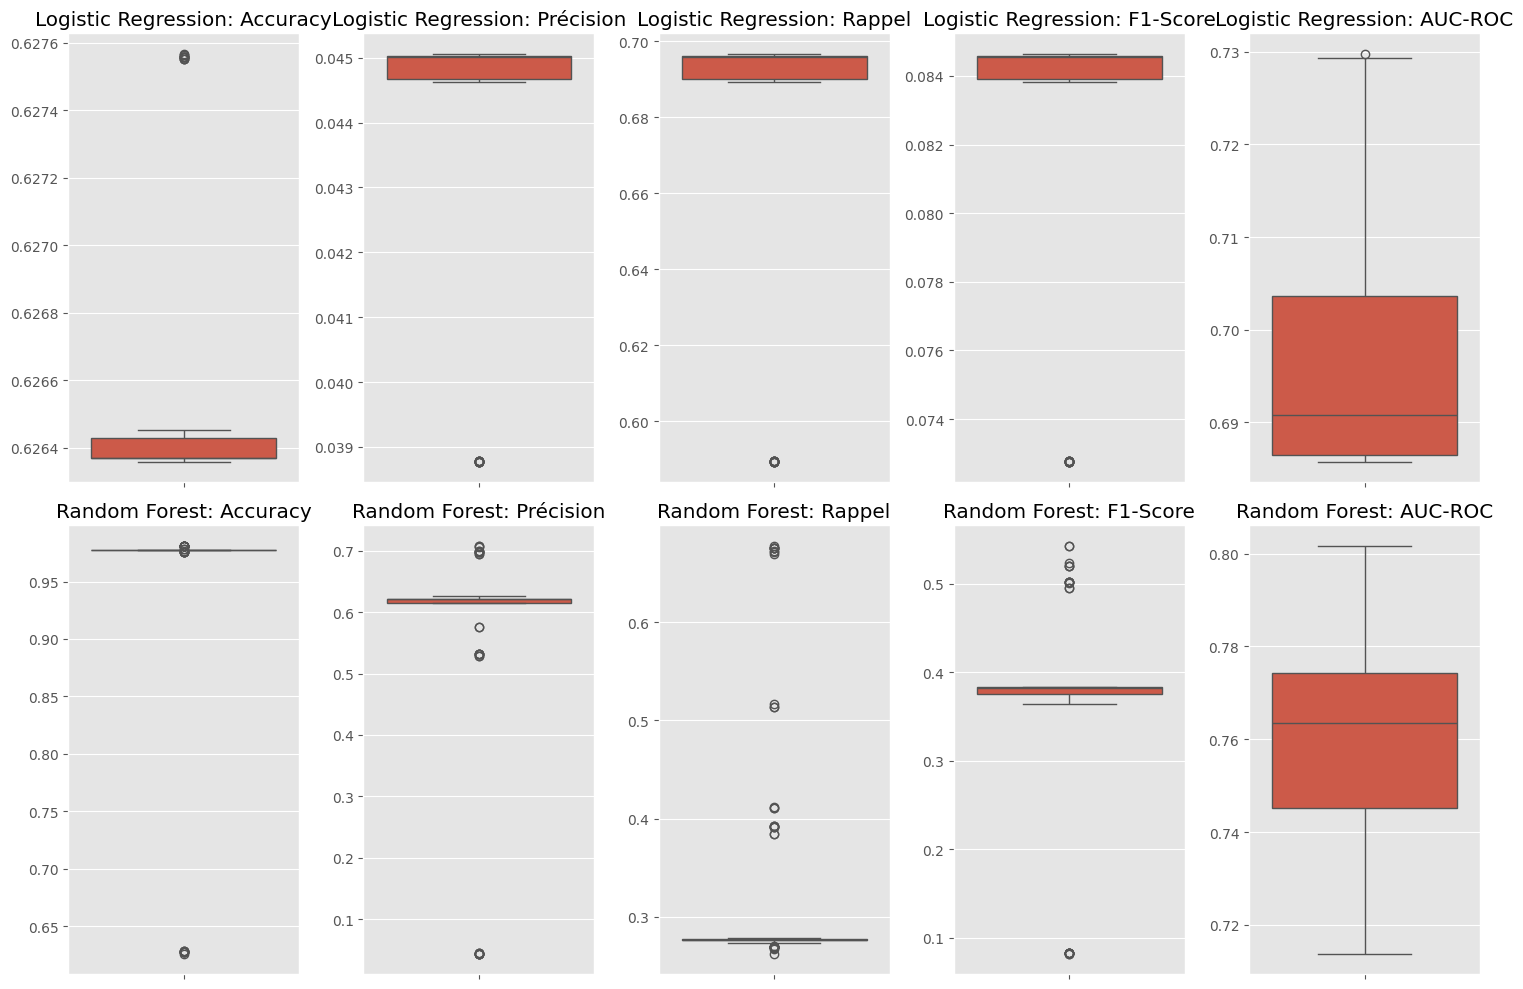

In [67]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Définir le nombre d'échantillons bootstrap ou répétitions
n_iterations = 100

# Préparer les données
label_mapping = {'Fail': 1, 'Success': 0}
train_df_reduced['Label'] = train_df_reduced['Label'].map(label_mapping)
valid_df_reduced['Label'] = valid_df_reduced['Label'].map(label_mapping)

X_train = train_df_reduced.drop(columns=['BlockId', 'Label', 'Type', 'Time', 'Date'])
y_train = train_df_reduced['Label']
X_valid = valid_df_reduced.drop(columns=['BlockId', 'Label', 'Type', 'Time', 'Date'])
y_valid = valid_df_reduced['Label']

# Initialiser les listes pour stocker les performances des modèles
metrics_lr = {"accuracy": [], "precision": [], "recall": [], "f1": [], "roc_auc": []}
metrics_rf = {"accuracy": [], "precision": [], "recall": [], "f1": [], "roc_auc": []}

# Boucle principale pour le bootstrap et la modélisation
for _ in range(n_iterations):
    # Créer un échantillon bootstrap
    bootstrap_sample = resample(train_df_reduced, replace=True, n_samples=len(train_df_reduced), random_state=None)
    X_train_bootstrap = bootstrap_sample.drop(columns=['BlockId', 'Label', 'Type', 'Time', 'Date'])
    y_train_bootstrap = bootstrap_sample['Label']
    
    # Entraîner Logistic Regression
    model_lr = LogisticRegression(max_iter=1000, random_state=None)
    model_lr.fit(X_train_bootstrap, y_train_bootstrap)
    y_pred_lr = model_lr.predict(X_valid)
    y_pred_proba_lr = model_lr.predict_proba(X_valid)[:, 1]
    
    # Calculer les métriques pour Logistic Regression
    metrics_lr["accuracy"].append(accuracy_score(y_valid, y_pred_lr))
    metrics_lr["precision"].append(precision_score(y_valid, y_pred_lr))
    metrics_lr["recall"].append(recall_score(y_valid, y_pred_lr))
    metrics_lr["f1"].append(f1_score(y_valid, y_pred_lr))
    metrics_lr["roc_auc"].append(roc_auc_score(y_valid, y_pred_proba_lr))
    
    # Entraîner Random Forest
    model_rf = RandomForestClassifier(n_estimators=100, random_state=None)
    model_rf.fit(X_train_bootstrap, y_train_bootstrap)
    y_pred_rf = model_rf.predict(X_valid)
    y_pred_proba_rf = model_rf.predict_proba(X_valid)[:, 1]
    
    # Calculer les métriques pour Random Forest
    metrics_rf["accuracy"].append(accuracy_score(y_valid, y_pred_rf))
    metrics_rf["precision"].append(precision_score(y_valid, y_pred_rf))
    metrics_rf["recall"].append(recall_score(y_valid, y_pred_rf))
    metrics_rf["f1"].append(f1_score(y_valid, y_pred_rf))
    metrics_rf["roc_auc"].append(roc_auc_score(y_valid, y_pred_proba_rf))

# Afficher les performances moyennes pour Logistic Regression
print("\nPerformances moyennes pour Logistic Regression:")
for metric, values in metrics_lr.items():
    print(f"{metric.capitalize()} moyenne: {np.mean(values):.4f}")

# Afficher les performances moyennes pour Random Forest
print("\nPerformances moyennes pour Random Forest:")
for metric, values in metrics_rf.items():
    print(f"{metric.capitalize()} moyenne: {np.mean(values):.4f}")

# Visualisation des performances
plt.figure(figsize=(15, 10))

metrics_names = ["accuracy", "precision", "recall", "f1", "roc_auc"]
titles = ['Accuracy', 'Précision', 'Rappel', 'F1-Score', 'AUC-ROC']

for i, metric in enumerate(metrics_names):
    plt.subplot(2, 5, i + 1)
    sns.boxplot(data=metrics_lr[metric])
    plt.title(f'Logistic Regression: {titles[i]}')
    
    plt.subplot(2, 5, i + 6)
    sns.boxplot(data=metrics_rf[metric])
    plt.title(f'Random Forest: {titles[i]}')

plt.tight_layout()
plt.show()


# Évaluation finale sur le test
Appliquer le meilleur modèle sur l'ensemble de test. Calculer la matrice de confusion et des métriques comme l'accuracy, la précision, le rappel, le F1-Score, et l'AUC-ROC.


--- Modèle : Logistic Regression ---
Accuracy sur le test: 0.9771
Précision sur le test: 0.5932
Rappel sur le test: 0.2669
F1-Score sur le test: 0.3681
AUC-ROC sur le test: 0.8789


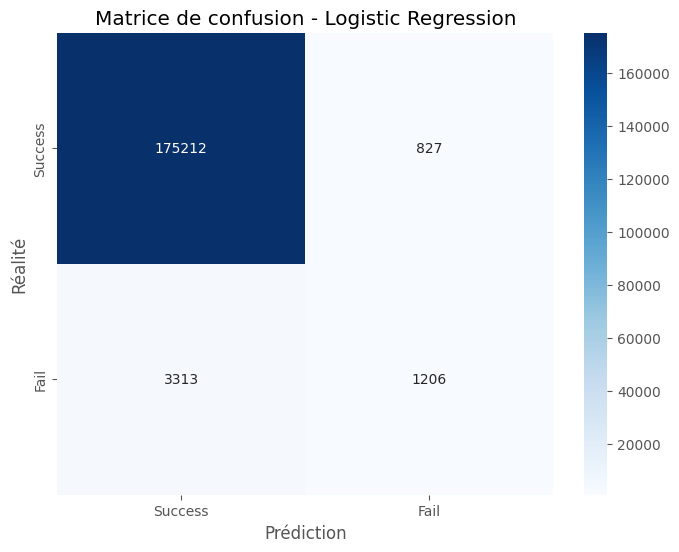

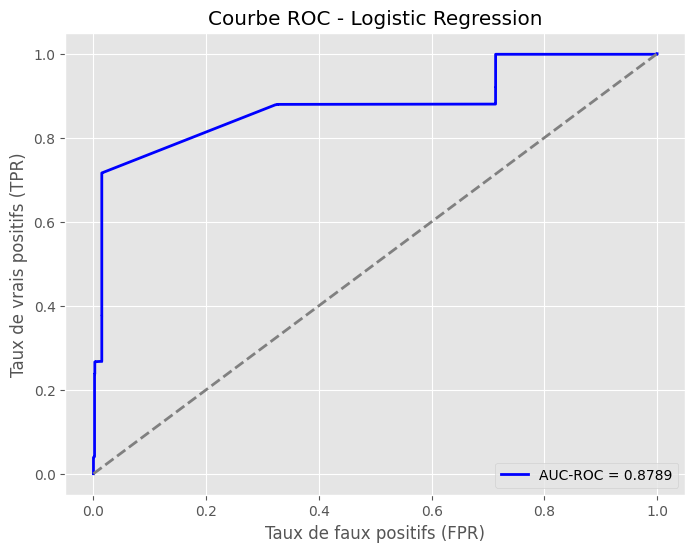


--- Modèle : Random Forest ---
Accuracy sur le test: 0.9830
Précision sur le test: 0.8015
Rappel sur le test: 0.4289
F1-Score sur le test: 0.5587
AUC-ROC sur le test: 0.8317


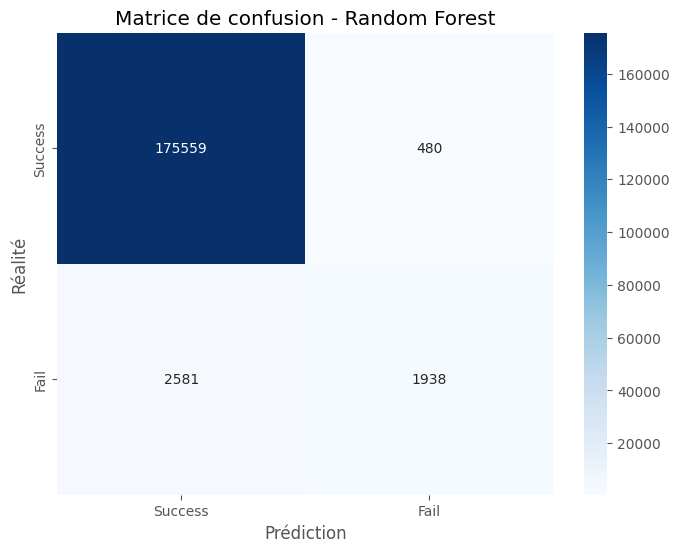

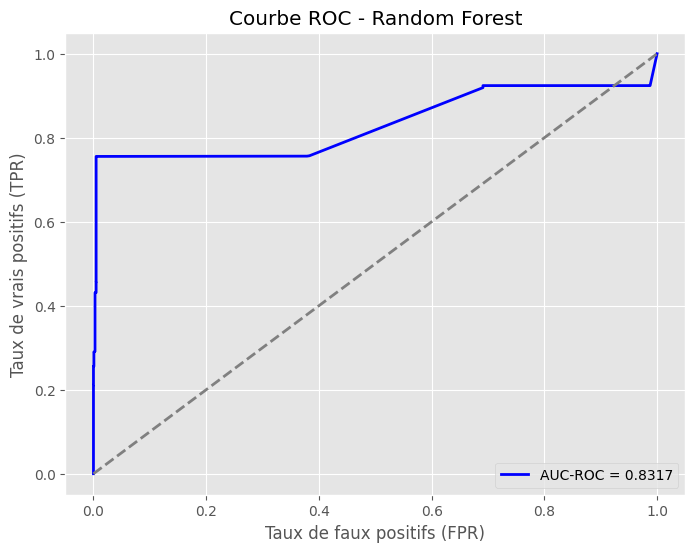


--- Comparaison des performances ---
                     Accuracy  Precision    Recall  F1-Score   AUC-ROC
Logistic Regression  0.977071   0.593212  0.266873  0.368132  0.878889
Random Forest        0.983047   0.801489  0.428856  0.558743  0.831676


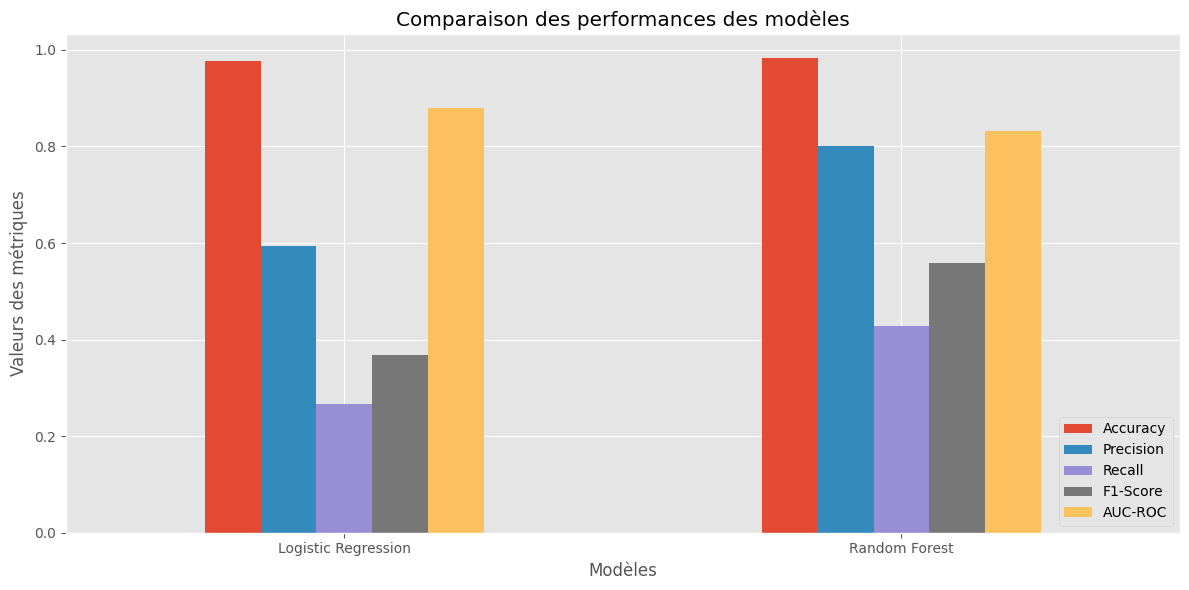

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine training and validation sets
X_train_full = pd.concat([X_train, X_valid])
y_train_full = pd.concat([y_train, y_valid])

# Prepare test set features and target
X_test = test_df_reduced.drop(columns=['BlockId', 'Label', 'Type', 'Time', 'Date'])
y_test = test_df_reduced['Label']

# Convert y_test to numerical values
label_mapping = {'Fail': 1, 'Success': 0}
y_test = y_test.map(label_mapping)

# Verify the conversion
if y_test.isnull().any():
    raise ValueError("y_test contains NaN values after mapping. Check the data.")

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Store performance metrics
metrics = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\n--- Modèle : {model_name} ---")
    # Train the model
    model.fit(X_train_full, y_train_full)

    # Predict on the test set
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate performance metrics
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)
    roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)

    # Store metrics
    metrics[model_name] = {
        "Accuracy": accuracy_test,
        "Precision": precision_test,
        "Recall": recall_test,
        "F1-Score": f1_test,
        "AUC-ROC": roc_auc_test
    }

    # Display performance metrics
    print(f"Accuracy sur le test: {accuracy_test:.4f}")
    print(f"Précision sur le test: {precision_test:.4f}")
    print(f"Rappel sur le test: {recall_test:.4f}")
    print(f"F1-Score sur le test: {f1_test:.4f}")
    print(f"AUC-ROC sur le test: {roc_auc_test:.4f}")

    # Calculate and display the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Success', 'Fail'], yticklabels=['Success', 'Fail'])
    plt.xlabel('Prédiction')
    plt.ylabel('Réalité')
    plt.title(f'Matrice de confusion - {model_name}')
    plt.show()

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC-ROC = {roc_auc_test:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title(f'Courbe ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Compare the performance metrics of the two models
print("\n--- Comparaison des performances ---")
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

# Visualize the comparison as a bar chart
metrics_df.plot(kind='bar', figsize=(12, 6), rot=0)
plt.title("Comparaison des performances des modèles")
plt.ylabel("Valeurs des métriques")
plt.xlabel("Modèles")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# Déterminer le meilleur modèle
Les performances des deux modèles sont affichées avec des valeurs pour chaque métrique.

Le modèle avec la meilleure performance globale est identifié et assigné à best_model.

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_full, y_train_full)
y_test_pred_lr = lr_model.predict(X_test)
y_test_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_full, y_train_full)
y_test_pred_rf = rf_model.predict(X_test)
y_test_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculer les métriques pour Logistic Regression
lr_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred_lr),
    "Precision": precision_score(y_test, y_test_pred_lr),
    "Recall": recall_score(y_test, y_test_pred_lr),
    "F1-Score": f1_score(y_test, y_test_pred_lr),
    "AUC-ROC": roc_auc_score(y_test, y_test_pred_proba_lr)
}

# Calculer les métriques pour Random Forest
rf_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred_rf),
    "Precision": precision_score(y_test, y_test_pred_rf),
    "Recall": recall_score(y_test, y_test_pred_rf),
    "F1-Score": f1_score(y_test, y_test_pred_rf),
    "AUC-ROC": roc_auc_score(y_test, y_test_pred_proba_rf)
}

# Comparer les métriques
print("\nPerformances de Logistic Regression:")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nPerformances de Random Forest:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value:.4f}")

# Décider du modèle avec la meilleure performance globale (exemple basé sur AUC-ROC)
if lr_metrics["AUC-ROC"] > rf_metrics["AUC-ROC"]:
    print("\nLogistic Regression a performé le mieux selon AUC-ROC.")
    best_model = lr_model  # Assigner Logistic Regression comme meilleur modèle
else:
    print("\nRandom Forest a performé le mieux selon AUC-ROC.")
    best_model = rf_model  # Assigner Random Forest comme meilleur modèle



Performances de Logistic Regression:
Accuracy: 0.9771
Precision: 0.5932
Recall: 0.2669
F1-Score: 0.3681
AUC-ROC: 0.8789

Performances de Random Forest:
Accuracy: 0.9830
Precision: 0.8015
Recall: 0.4289
F1-Score: 0.5587
AUC-ROC: 0.8317

Logistic Regression a performé le mieux selon AUC-ROC.


# Interprétation du modèle AiOps


Importance des variables - Régression Logistique :
   Variable  Importance
10      E17   11.501517
12      E19   10.738279
8       E15    9.627122
7       E11    6.337130
9       E16    6.262332
11      E18    4.033895
13      E20    3.799019
20      E29    3.460550
15      E24    2.214030
17      E26    1.448977
14      E22    1.438340
1        E3    1.149835
16      E25    1.032614
2        E5    0.995793
19      E28    0.990389
5        E9    0.521932
18      E27    0.431992
3        E7    0.112744
0        E1    0.110939
4        E8    0.042786
6       E10    0.023682

Importance des variables - Random Forest :
   Variable  Importance
8       E15    0.214237
0        E1    0.171245
10      E17    0.113567
2        E5    0.111674
9       E16    0.108438
7       E11    0.066804
5        E9    0.063137
12      E19    0.047303
1        E3    0.033600
3        E7    0.025522
11      E18    0.019054
4        E8    0.015479
6       E10    0.006327
13      E20    0.000977
15      E24    0

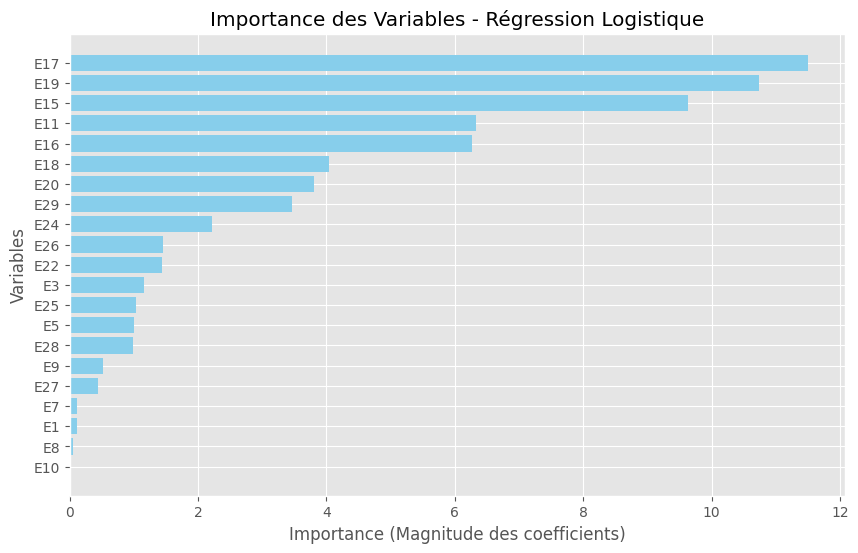

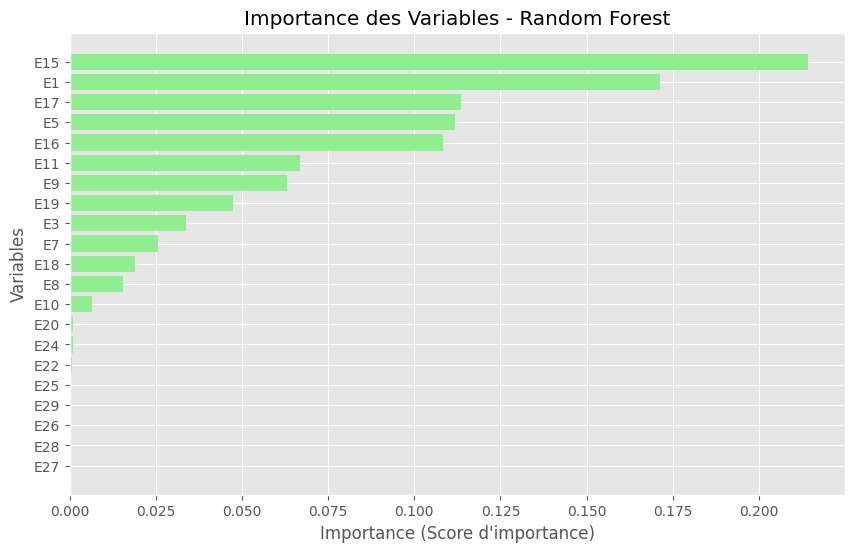


Comparaison des importances des variables :
   Variable  Importance_LogisticRegression  Importance_RandomForest
0       E17                      11.501517                 0.113567
1       E19                      10.738279                 0.047303
2       E15                       9.627122                 0.214237
3       E11                       6.337130                 0.066804
4       E16                       6.262332                 0.108438
5       E18                       4.033895                 0.019054
6       E20                       3.799019                 0.000977
7       E29                       3.460550                 0.000284
8       E24                       2.214030                 0.000794
9       E26                       1.448977                 0.000251
10      E22                       1.438340                 0.000640
11       E3                       1.149835                 0.033600
12      E25                       1.032614                 0.000368
13 

<Figure size 1200x800 with 0 Axes>

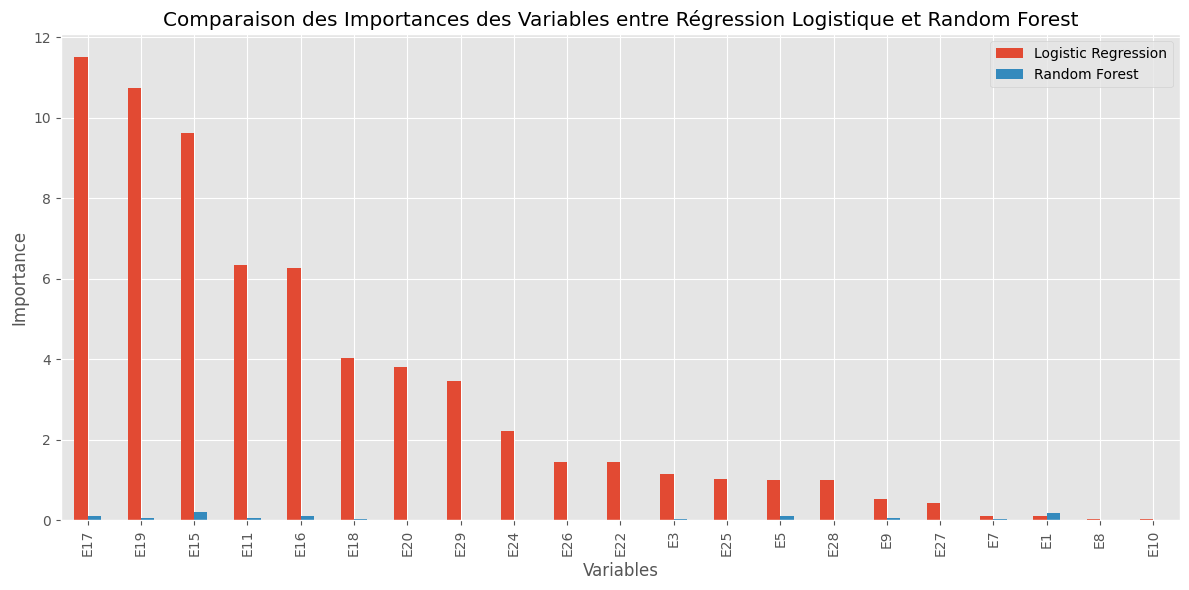

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Extraire les coefficients pour Logistic Regression
coefficients = best_model.coef_[0]  # Coefficients du modèle Logistic Regression
feature_names = X_train_full.columns  # Noms des variables dans l'ensemble combiné

# Calculer l'importance des variables pour Logistic Regression
logistic_importances = pd.DataFrame({
    'Variable': feature_names,
    'Importance': np.abs(coefficients)  # Valeurs absolues des coefficients
}).sort_values(by='Importance', ascending=False)

# Entraîner un modèle Random Forest pour comparer les importances des variables
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_full, y_train_full)

# Calculer l'importance des variables pour Random Forest
rf_importances = pd.DataFrame({
    'Variable': feature_names,
    'Importance': rf_model.feature_importances_  # Importances données par Random Forest
}).sort_values(by='Importance', ascending=False)

# Afficher les importances pour Logistic Regression
print("\nImportance des variables - Régression Logistique :")
print(logistic_importances)

# Afficher les importances pour Random Forest
print("\nImportance des variables - Random Forest :")
print(rf_importances)

# Visualisation des importances pour Logistic Regression
plt.figure(figsize=(10, 6))
plt.barh(logistic_importances['Variable'], logistic_importances['Importance'], color='skyblue')
plt.xlabel('Importance (Magnitude des coefficients)')
plt.ylabel('Variables')
plt.title('Importance des Variables - Régression Logistique')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher les plus importantes en haut
plt.show()

# Visualisation des importances pour Random Forest
plt.figure(figsize=(10, 6))
plt.barh(rf_importances['Variable'], rf_importances['Importance'], color='lightgreen')
plt.xlabel('Importance (Score d\'importance)')
plt.ylabel('Variables')
plt.title('Importance des Variables - Random Forest')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher les plus importantes en haut
plt.show()

# Comparaison des importances entre les deux modèles
comparison = logistic_importances.merge(
    rf_importances, on='Variable', suffixes=('_LogisticRegression', '_RandomForest')
)

# Afficher la comparaison
print("\nComparaison des importances des variables :")
print(comparison)

# Visualisation de la comparaison
plt.figure(figsize=(12, 8))
comparison.plot(x='Variable', kind='bar', figsize=(12, 6))
plt.title("Comparaison des Importances des Variables entre Régression Logistique et Random Forest")
plt.ylabel("Importance")
plt.xlabel("Variables")
plt.legend(["Logistic Regression", "Random Forest"])
plt.tight_layout()
plt.show()
